<a href="https://colab.research.google.com/github/zaicevairina/2020-2-Atom-QA-Python-I-Zaitseva/blob/master/%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7_%D0%A7%D0%B0%D1%81%D1%82%D1%8C_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import ttest_power
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import GofChisquarePower
import statsmodels.stats.power as power
import statsmodels.stats.multitest as multitest

# Ошибка второго рода и статистическая мощность

## Освежим знания с прошлого занятия

Давайте вспомним знакомую нам таблицу с ошибками первого и второго рода:

![errors](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ1ce6-OOtY2aN10Z60e5WlI3e7SE457EjKLJ79_DeiRMiL0bVZ&usqp=CAU)

На прошлом занятии мы подробно обсудили все, что связано с ошибкой первого рода.
<br> **Кратко вспомним ключевое**

* уровень значимости - задаеваемая нами вероятность отклонения нулевой гипотезы, когда она была действительно верной. То есть максимальная вероятность совершения ошибки первого рода. Другая интерпретация: уровень значимости — это такое (достаточно малое) значение вероятности события, при котором событие уже можно считать неслучайным.
* критическая область - область значений статистики критерия, при которых мы оклоняем нулевую гипотезу, то есть это такие значения статистики критерия, вероятность получить значения которые меньше или равна нашему уровню значимости;
* p-value - кумулятивная вероятность получения определенного значения статистики критерия. То есть вероятность получения результата, равного или более экстремального, чем наблюдалось в данных.

**Например**

Мы проверяем **двустороннюю** гипотезу о равенстве средних двух выборок длиной по 200 элементов с помощью критерия Стьюдента и задааем уровень значимости равный **0,01**. Проводим тест и получаем t-статистику, равную **2**. Что это значит?

1) При заданном уровне значимости, мы говорим, что мы не примем нулевую гипотезу о равенстве средних если кумулятивная вероятность получения такого значения t-статистики, которое мы получили, будет меньше, чем 0,01 (1%).

Всмпомнить про распредеение t-статистики (распределение Стьюдента) - https://wiki.loginom.ru/articles/students-distribution.html

In [ ]:
t_vals = np.random.standard_t(398, size = 10000)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

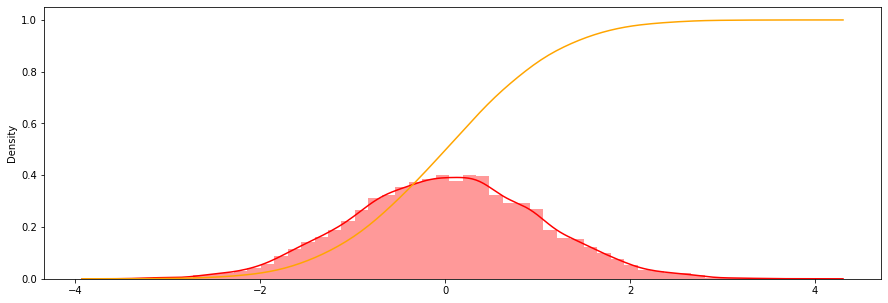

In [ ]:
plt.figure(figsize=(15,5));
sns.distplot(t_vals, kde = True, hist = True, color = 'red')
sns.distplot(t_vals, hist = False,hist_kws={'cumulative': True}, kde_kws={'cumulative': True}, color = 'orange')

In [ ]:
p_value = stats.t.cdf(-2, 398) * 2

In [ ]:
p_value = 2 - stats.t.cdf(2, 398) * 2

In [ ]:
p_value

0.04617934453132455

2) мы получили p-value = 0,046. Это значит, что вероятность получить значение t-статистики = 2 или -2, равняется 0,046 (4,6%). Это больше, чем мы закладывали, поэтому в рамках нашего эксперимента гипотеза о равенстве средних отклоняется.

## Вспомним про ошибку второго рода и определим, что такое мощность критерия

Мы достаточно глубоко погрузились в специфику работы с ошибкой первого рода,но совсем не думали об ошибке второго рода.

Но если мы имеем вероятность принять нулевую гипотезу ошибочно, то важно уметь оценивать эту вероятность и все, что из нее следует.

<img width = '400px' src= https://memepedia.ru/wp-content/uploads/2018/10/1-82.jpg>

Вспомним, что **ошибка второго рода** - принятие нулевой гипотезы, когда в действительности она ложна и между сравниваемыми параметрами есть значимая разница, которую мы не обнаружили.

И если уровень значимости, контролирующий ошибку первого рода помогает нам вычислить вероятность правильного принятия нулевой гипотезы (доверительную вероятность), которая равняется 1 - уровень значимости, то ошибка второго рода помогает нам определить вероятность правильного принятия альтернативной гипотезы (H1), которая равняется 1 - вероятность ошибки второго рода и чаще называется мощностью или чувствительностью критерия. Ошибка второго рода не задается нами перед началом теста, так как образуется только в том случае, если мы отклоняем нулевую гипотезу.

Таким образом

**Статистическая мощность** - это вероятность того, что данный эксперимент правильно отвергает нулевую гипотезу, когда альтернативная гипотеза верна.  Чем выше мощность статистического теста, тем меньше вероятность совершить ошибку второго рода.

Рассмотрим на примере, для ясности

Сгенерируем 2 похожие,  нормально распределенные выборки с небольшой разницей в среднем

In [ ]:
ex_1 = np.random.normal(50,5,1000)
ex_2 = np.random.normal(50.7,5,1000)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'test')

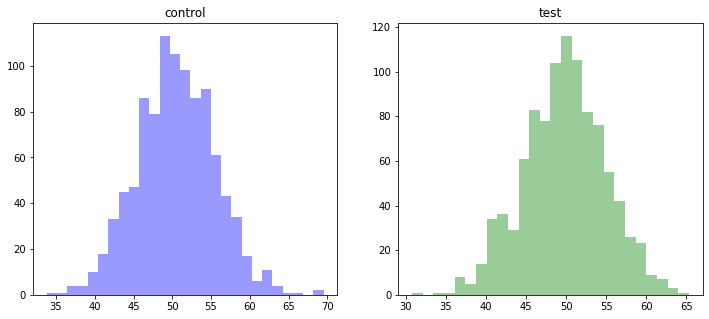

In [ ]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(ex_2,color = 'blue',hist = True, kde = False,ax = ax)
ax.set_title('control')

ax=f.add_subplot(122)
sns.distplot(ex_1,color = 'green',hist = True, kde = False,ax=ax)
ax.set_title('test')

Проведем сравнение с помощью критерия Стьюдента

In [ ]:
t, p = stats.ttest_ind(ex_1,ex_2)


if p > 0.05:
    print('Нет статистически значимой разницы','\nt - критерий = ',t,'\np-value =',p)
else:
    print('Есть статистически значимая разница','\nt - критерий = ',t,'\np-value =',p)

Есть статистически значимая разница 
t - критерий =  -3.335054751651104 
p-value = 0.000868426322727329


Статистическая значимость есть. А с какого момента все же она начинает появляться? Посмотрим на критическое значение, с которого начинается критическая область - область отторжения нулевой гипотезы.

In [ ]:
stats.t.ppf(q= .05/2,df=1998) #делим на 2 так как у нас двусторонняя гипотеза

-1.961152014836706

 Мы бы отвергаем  нулевую гипотезу, когда наше t значение меньше -1.961 или больше 1.961.

In [ ]:
t_values = np.random.standard_t(1998, size = 1000)

<AxesSubplot:ylabel='Density'>

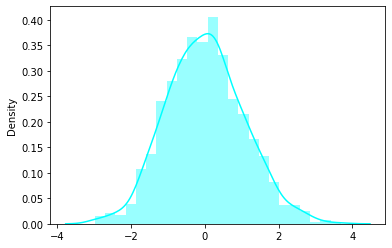

In [ ]:
sns.distplot(t_values, kde = True, hist = True, color = 'cyan')

Вся область распределения от -1.961 до 1.961 является областью принятия нулевой гипотезы, и точно также у нас есть область отклонения нулевой гипотезы, то есть принятия альтернативной гипотезы.

Распредление статистики критерия, которое отображает как распределяется статистика критерия, когда нулевая гипотеза верна называется **центральным распределением**, а распределение статистики критерия, которое показывает, как она распределится, когда нулевая гипотеза не верна называется **нецентральным распределением**.

Нецентральные распределения - это семейства вероятностных распределений , которые связаны с другими «центральными» семействами распределений с помощью параметра нецентральности . В то время как центральное распределение описывает, как распределяется тестовая статистика, когда проверяемая разница равна нулю , нецентральные распределения описывают распределение тестовой статистики, когда нулевое значение ложно (так что альтернативная гипотеза верна). Это приводит к их использованию при расчете статистической мощности .

Если параметр нецентральности распределения равен нулю, распределение идентично распределению в центральном семействе. Так , например, в Стьюденте т -распределение является центральным семейством распределений для нецентрального т -распределения семьи.

https://en.wikipedia.org/wiki/Noncentral_distribution

![p](https://i.pinimg.com/originals/9c/0b/4d/9c0b4dc10c1ff838eefd4807ee48d3e7.png)

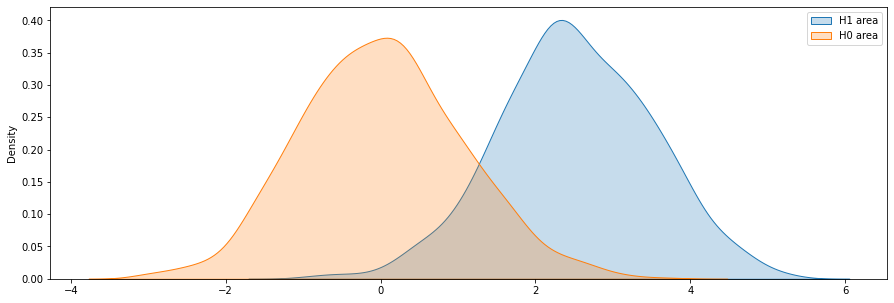

In [ ]:
plt.figure(figsize=(15,5));
sns.kdeplot(stats.nct.rvs(1998,2.5,size = 1000),shade = True);
sns.kdeplot(t_values,shade = True).legend(['H1 area','H0 area'])


Так как мы выявили статистическую значимость и отклонили нулевую гипотезу, для нас уместно понять, насколько точно нами была принята альтернативная гипотеза и какова вероятность, что мы все таки совершили ошибку второго рода.

Для начала необходимо рассчитать статистическую мощность - вероятность того, что нулевая гипотеза была отвергнута верно. 

Анализ мощности может проводиться перед началом теста (для определения размера выборки), а также после (для уверенности в результате и проверки насколько результат изменится при разной величине эффекта или объеме выборки)

## Расчет статистической мощности, что нам требуется?

Что требуется для того, что рассчитать статистическую мощность?

### размер эффекта (effect size)

![img](https://miro.medium.com/max/1000/1*o-T-W0cDXkBAZfrvKJZMHg.jpeg)

В некторых тестах мы наблюдаем количественно большую разницу, а в некоторых совсем небольшую. Например, наша конверсия может измениться на 1% и это будет иногда значимо а иногда нет, также и на 5-10%. Конечно это зависит от объема выборки, однако очень важно понимать, как же адекватно оценивать размер эффекта? Для этого существует целая группа индексов, оценивающих силу эффекта стандартизированно. 

**Размер эффекта**  определяется как количественное отражение величины (степени проявления) некоторого явления, которое используется для решения интересующего вопроса. 
<br> Следует отметить, что размер эффекта (ES) – обозначение целого семейства индексов, которые оценивают значение эффекта воздействия. В качестве размера эффекта может быть использована абсолютная и стандартизированная разница между средними значениями в исследуемых группах, степень взаимосвязи между признаками, оценка шансов и рисков, оценка пропорций, соответствие или несоответствие определенной модели и т. д.

https://en.wikipedia.org/wiki/Effect_size

Размер эффекта позволяет стандартизированно ответить на вопрос сильное изменение или нет.

Для каждого критерия существуют свои индексы размера эффекта

1) t-test - d Коэна, g Ходжеса;
<br>2) хи-квадрат - коэффицент корреляции;
<br>3) ранговые критерии (Манна Уитни и тд) - рангово-бисериальная корреляция.

**Рассчитаем размер эффекта  d Коэна для нашего случая**

d Коэна  - величина эффекта, используемая для обозначения стандартизированной разницы между двумя средними. Его можно использовать, например, для сопровождения отчетов о результатах t- теста и ANOVA . Он также широко используется в метаанализе .
<br>.  **Рассчитывается как разница между средними, деленная на объединенное стандратное отклонение**

 Объединенное стандартное отклонение - взвешенное среднее из стандартных отклонений для двух или более групп. Отдельные стандартные отклонения усредняются, причем больший «вес» придается большему размеру выборки.

Формула расчета 

![d](https://i.pinimg.com/originals/bc/de/b1/bcdeb114028c1828056821fc07c303ad.png)

In [ ]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [ ]:
cohend(ex_2,ex_1)

0.14914818266751093

### Уровень значимости
Следующее, что нам необходимо для расчета мощности - уровень значимости, на котором проверяем гипотезу, его мы знаем)

### Длина выборки

Суммарное количество элементов в выборках, это мы тоже знаем)

### Критическая область
Какую гипотезу проверяем: левостороннюю, правостороннюю, двустороннюю

###  Вычислим статистическую мощность

Объяснение формулы:

* https://stattrek.com/hypothesis-test/statistical-power.aspx
* https://towardsdatascience.com/a-quick-refresher-of-statistical-power-fe8ae5e0c317

In [ ]:
power = ttest_power(cohend(ex_2,ex_1), nobs=1000, alpha=0.05, alternative='two-sided')

In [ ]:
power

0.997038145767443

Ну и таким образом ошибка второго рода

In [ ]:
beta = 1 - power

In [ ]:
beta

0.002961854232557015

## Использование мощности и размера эффекта для расчета объема выборки перед проведением теста

**Размер эффекта**

Мы уже знаем, как рассчитать размер эффекта, но если перед нами стоит задача определить, какой размер выборки нам нужен, чтобы качественно провести проверку статистической гипотезы, то мы еще не знаем реального размера эффекта и мощности.

Но! Мы знаем, что хотим увидеть)

Для размера эффекта существует условное деление,относящее эффект к маленькому, среднему, большому. Границы зависят от выбранного индекса размера эффекта, для d Коэна это:

![s](https://www.simplypsychology.org/cohen-d.jpg?ezimgfmt=rs:382x181/rscb24/ng:webp/ngcb24)

Соответственно, перед запуском теста нам важно оценить, какое изменение мы ожидаем увидеть. Если у нас есть сомнение и у нас есть возможность собрать большой объем выборки, то можно отсмотреть с разными размерами эффекта.

**Мощность**

Мы также не знаем, какая мощность будет у нашего теста, поэтому можем выбрать желаемое значение. Минимально допустимым считается значение 0,8 (то есть вероятность ошибки второго рода не должна превышать 0,2). Однако в любом случае необходимо отталкиваться от конкретного теста, ситуации и наших объемов данных

## Примеры расчета объема выборки

Используя наши знания и существующий функционал проведем экспериментальный расчет объема выборки для разных известных нам критериев

### для критерия Стьюдента

In [ ]:
effect = 0.01
alpha = 0.05
power = 0.8

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=2, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 117733.550


### для критерия хи-квадрат

в качестве размера эффекта используется коэффициент корреляции

In [ ]:
chipower = GofChisquarePower()
chipower.solve_power(0.01, nobs=None, alpha=0.005, power=0.95)

198193.01380553763

Документация для расчета мощности для других критериев
<br> https://www.statsmodels.org/stable/search.html?q=power

# Познакомимся со множественными сравнениями

### Узнаем подробнее про критерий хи-квадрат и проведем множественное сравнение

**!! Пример хи квадрат с двумя группами представлен в ноутбуке прошлой лекции**

Критерий Хи-квадарт позволяет нам сравнить отношения количества успеха к неуспехам в двух таблицах.Под успешным можем подразумевать не только совершение действия, но и любое желаемое число, например можем сравнить доли успешно закрытых заказов, доли женщин студентов от всей группы и так далее. Позволяет сравнивать больше чем два значения и довольно таки эффективно.

Формула для его вычисления

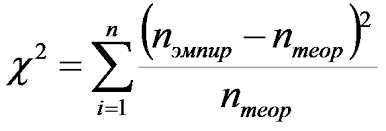


**Задача**

Мы решили разместить на главном экране приложения новую кнопку, которая ведет в раздел с активацией подписок. У нас есть 3 варианта дизайна этой кнопки и мы хотим выбрать тот, который будет максимально привлекать внимание пользователей. Для этого нам нужно провести сравнение трех групп. В качестве критерия используем хи квадрат.

<img width = '300px' src=https://img2.goodfon.ru/wallpaper/nbig/3/15/colored-circles-cvetnye-krugi.jpg>

Эмпимрические значения - это те значения, которые мы получили на практике, в нашем случае это нашии реальные конверсии в открытие раздела с подписками, а теоретические, это те конверсии, которые бы мы получили, если бы была верна нулевая гипотеза об отсутствии значимого различия, то есть они должны быть равны.

In [ ]:
d = {'group':['a','b','c'],'success':[12000,11000,12100],'all':[200000,199451,201001]}

In [ ]:
df = pd.DataFrame(d)

In [ ]:
df

,group,success,all
0,a,12000,200000
1,b,11000,199451
2,c,12100,201001


Давайте подумаем, какие у нас есть пути решения данной задачи?

1) сравнить все группы между собой и определить, есть ли между ними разница;
<br>2) сравнить группы попарно и определить, между какими кнопками конкретно есть разница

Как правило, нас интересует второй вариант, так как сам факт наличия значимой разницы между тремя группами нам ничего не даст

Нам нужно будет провести 3 сравнения:
* a vs b (blue vs red)
* b vc c ( red vs orange)
* a vs c ( blue vs orange)

В таких случаях и возникает проблема множественных сравнений

**Чем больше попарных сравнений мы проводим, тем выше вероятность допустить ошибку**

Для решения данной проблемы при сравнении больше чем 2х групп между собой попарно, необходимо учитывать специфику проведения множественных сравнений.

### Алгоритм проведения множественного сравнения

1) проведение попарного сравнения групп с помощью выбранного критерия;
<br> 2) применение поправки на множественное сравнение для корректировки уровня значимости либо выбор достаточно маленького значения уровня значимости

#### Поправка Бонферрони

Поправка Бонферрони - довольно таки известная, простая в реализации поправка. Однако это и делает ее критикуемой многими специалистами.

Уровень значимости с помошью поправки Бонферрони корректируется по следующей формуле:

**Новый уровень значимости** = уровень значимости/количество сравнений


Нулевая гипотеза отвергается когда p-value меньше нового уровня значимости

In [ ]:
a = df[df['group'] == 'a'].drop('group',axis = 1)
b = df[df['group'] == 'b'].drop('group',axis = 1)
c = df[df['group'] == 'c'].drop('group',axis = 1)

1) blue vs red

In [ ]:
stat = stats.chi2_contingency(pd.concat([a,b]))
if stat[1] > 0.01/3:
    print('p-value =',stat[1],'\nchi stat = ',stat[0],'\nнет значимой разницы','\nТеоретические значения-',stat[3])
else:
    print('p-value =',stat[1],'\nchi stat = ',stat[0],'\nесть значимая разница','\nТеоретические значения-',stat[3])

p-value = 5.561780012021683e-10 
chi stat =  38.469440080958435 
есть значимая разница 
Теоретические значения- [[ 11542.16702055 200457.83297945]
 [ 11457.83297945 198993.16702055]]


2) Red vs orange

In [ ]:
stat = stats.chi2_contingency(pd.concat([b,c]))
if stat[1] > 0.01/3:
    print('p-value =',stat[1],'\nchi stat = ',stat[0],'\nнет значимой разницы','\nТеоретические значения-',stat[3])
else:
    print('p-value =',stat[1],'\nchi stat = ',stat[0],'\nесть значимая разница','\nТеоретические значения-',stat[3])

p-value = 1.0561807671168348e-10 
chi stat =  41.71458633833578 
есть значимая разница 
Теоретические значения- [[ 11477.73614574 198973.26385426]
 [ 11622.26385426 201478.73614574]]


3) Blue vs orange

In [ ]:
stat = stats.chi2_contingency(pd.concat([a,c]))
if stat[1] > 0.01/3:
    print('p-value =',stat[1],'\nchi stat = ',stat[0],'\nнет значимой разницы','\nТеоретические значения-',stat[3])
else:
    print('p-value =',stat[1],'\nchi stat = ',stat[0],'\nесть значимая разница','\nТеоретические значения-',stat[3])

p-value = 0.8082984677245291 
chi stat =  0.05886529026508783 
нет значимой разницы 
Теоретические значения- [[ 12018.79082853 199981.20917147]
 [ 12081.20917147 201019.79082853]]


Какие результаты получили?

* есть значимая разница между красной и оранжевой кнопкой;
* есть значимая разница между голубой и красной кнопкой;
* нет значимой разницы между голубой и оранжевой кнопкой

In [ ]:
df['conv'] = round(df['success']/df['all'],4)

In [ ]:
df

,group,success,all,conv
0,a,12000,200000,0.0600
1,b,11000,199451,0.0552
2,c,12100,201001,0.0602


Таким образом, красная кнопка показывает конверсию значимо НИЖЕ, чем голубая и оранжевая кнопки. Между оранжевой и голубой кнопкой разницы нет.

#### Поправка Холма-Бонферрони

Метод Холма - Бонферрони - также называемый методом Холма,используется для борьбы с проблемой множественных сравнений. Является модификацией поправки Бонферрони и позволяет решать проблему излишней жесткости при большом количестве сравнений.

Формула для определения уровня значимости

![hb](https://www.statisticshowto.com/wp-content/uploads/2016/09/holm-bonferroni-2-1.png)

* target alpa level - наш изначальный уровень значимости,заданный нами (0.05 например);
* n - количество сравнений
* rank number of pair - номер полученного p-value при сортировке от  меньшего к большему

Работаем с тем же примером)

Для начала нам надо получить p-value для каждого парного сравнения и отстортировать их от меньшего к большему

In [ ]:
pvals = [stats.chi2_contingency(pd.concat([a,b]))[1],stats.chi2_contingency(pd.concat([b,c]))[1],stats.chi2_contingency(pd.concat([a,c]))[1]]

In [ ]:
pvals

[5.561780012021683e-10, 1.0561807671168348e-10, 0.8082984677245291]

 Отсортируем

In [ ]:
sort_values = sorted(pvals)

In [ ]:
sort_values

[1.0561807671168348e-10, 5.561780012021683e-10, 0.8082984677245291]

In [ ]:
def Holm_Bonferroni(data):
    for i in data:
        if i < 0.05/(len(data) - (data.index(i) + 1) + 1):
            print ('Не можем  принять гипотезу H0','\ncorrected_alpha=',0.05/(len(data) - (data.index(i) + 1) + 1),
                   '\np_value = ',i)
        else:
            print('Не можем отклонить гипотезу H0','\ncorrected_alpha=',0.05/(len(data) - (data.index(i) + 1) + 1),
                 '\np_value = ',i)

In [ ]:
Holm_Bonferroni(sort_values)

Не можем  принять гипотезу H0 
corrected_alpha= 0.016666666666666666 
p_value =  1.0561807671168348e-10
Не можем  принять гипотезу H0 
corrected_alpha= 0.025 
p_value =  5.561780012021683e-10
Не можем отклонить гипотезу H0 
corrected_alpha= 0.05 
p_value =  0.8082984677245291


Реализация statsmodels - https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

В целом, распространена практика вместо применения поправок брать очень маленький уровень значимости изначально. При большом объеме данных проверка гипотез при уровне значимости <= 0.001 вполне допустима.